In [4]:
import numpy as np
import openpnm as op
import porespy as ps
import matplotlib.pyplot as plt
import pandas as pd
import os
from openpnm.models import physics as mods
from scipy import stats
from skimage.measure import euler_number

In [5]:

def invasion(phase,inlets):
    OP_1 = op.algorithms.OrdinaryPercolation(network=pn,phase=phase)
    OP_1.set_inlets(pores=inlets)
    OP_1.setup(phase=air, pore_volume='pore.volume', throat_volume='throat.volume')
    OP_1.run(points=100)
    return OP_1

def network_extract(im,resolution):

    snow = ps.networks.snow(
    im=im,
    voxel_size=resolution)

    proj = op.io.PoreSpy.import_data(snow)

    return proj


def update_phase_and_phys_water(results):
    # convert results to boolean matrix
    results['pore.occupancy'] = results['pore.occupancy'].astype(int) > 0
    results['throat.occupancy'] = results['throat.occupancy'].astype(int) > 0
    val = np.amin(phys_water['throat.hydraulic_conductance'])/1000

    # results: pore and throats occupancy
    air.update(results)
    # if stokes flow of water, we need to update phys_water hydraulic conductance.
    #  The percoaltion result is always refering to air since this is phase we we are using to invade
    # Therefore, locations where water hydraulic conductance is slow indicate gas saturated
    phys_water['throat.hydraulic_conductance'][air['throat.occupancy']] = val

def update_phase_and_phys_air(results):
    val = np.amin(phys_water['throat.hydraulic_conductance'])/1000

    results['pore.occupancy'] = results['pore.occupancy'].astype(int) > 0
    results['throat.occupancy'] = results['throat.occupancy'].astype(int) > 0
    # results: pore and throats occupancy
    air.update(results)
    # if stokes flow of air, we need to update phys_air hydraulic conductance.
    # Therefore, locations where air hydraulic conductance is slow indicate water saturated
    phys_air['throat.hydraulic_conductance'][~air['throat.occupancy']] = val


def cal_absolute_perm(image_size,resolution,Q):
    A = (image_size*image_size) *resolution**2 # m^2
    L = image_size * resolution # m
    mu = water['pore.viscosity'].max() # N s/m^2 or Pa s
    delta_P = 1 # 1-0
    K = Q * L * mu / (A * delta_P)
    return K/0.98e-12*1000

def cal_eff_perm(image_size,resolution,Q,phase):
    A = (image_size*image_size) *resolution**2
    L = image_size * resolution
    mu = phase['pore.viscosity'].max() # N s/m^2 or Pa s
    delta_P = 1
    K = Q * L * mu / (A * delta_P)

    return K/0.98e-12*1000

In [3]:
ws = op.Workspace()
np.random.seed(10)
np.set_printoptions(precision=4)
resolution = 2.32e-06
im_shape = 128
# initialization
inlet = 'left'
outlet = 'right'
resolution = 2.25e-6 
im = np.load('1.npy')
snow = ps.networks.snow(
im=im,
voxel_size=resolution)

proj = op.io.PoreSpy.import_data(snow)
pn,geo = proj[0],proj[1]
data_tmp = {}

data_tmp['coordination'] = np.mean(pn.num_neighbors(pn.Ps))
data_tmp['porosity'] = ps.metrics.porosity(im)
data_tmp['pore.diameter'] = np.mean(geo['pore.diameter'])
data_tmp['throat.diameter'] = np.mean(geo['throat.diameter'])
data_tmp['euler'] = euler_number(im,connectivity=3)

health = pn.check_network_health()
op.topotools.trim(network=pn, pores=health['trim_pores'])

------------------------------------------------------------
Beginning SNOW Algorithm
Converting supplied image (im) to boolean
Peforming Distance Transform
Applying Gaussian blur with sigma = 0.4
Initial number of peaks:  249
Peaks after trimming saddle points:  143
Peaks after trimming nearby peaks:  143
------------------------------------------------------------
Extracting pore and throat information from image
100%|██████████| 243/243 [00:01<00:00, 209.73it/s]


In [5]:
if ( (len(pn.pores('top')) > 0) & (len(pn.pores('bottom')) > 0) ):
    inlet = 'top'
    outlet = 'bottom'

elif ( (len(pn.pores('left')) > 0) & (len(pn.pores('right')) > 0) ):
    inlet = 'left'
    outlet = 'right'

elif ( (len(pn.pores('front')) > 0) & (len(pn.pores('back')) > 0) ):
    inlet = 'front'
    outlet = 'back'
else:
    print('Condition not satisfied')

inlets = pn.pores(inlet)
outlets = pn.pores(outlet)

# define phase and physics
air = op.phases.Air(network=pn)
water = op.phases.Water(network=pn)
water['pore.contact_angle'] = 0
air['pore.contact_angle'] = 180
phys_air = op.physics.Standard(network=pn, phase=air, geometry=geo)
phys_water = op.physics.Standard(network=pn, phase=water, geometry=geo)

# perform invasion flow simulation
OP_1=invasion(air,inlets)
data = OP_1.get_intrusion_data()
sw = [1-x for x in data.Snwp]
snw = data.Snwp

------------------------------------------------------------
SOURCE     : openpnm.algorithms.OrdinaryPercolation.get_intrusion_data 
TIME STAMP : 2023-03-12 11:21:50,271
------------------------------------------------------------


In [7]:
phys_water.regenerate_models()
st = op.algorithms.StokesFlow(network=pn)
st.setup(phase=water)
st.set_value_BC(pores=inlets, values=0)
st.set_value_BC(pores=outlets, values=1) # this part needs some validation
st.run()
Q_abs_water = st.rate(pores=outlets,mode='group')
kabs_tmp = cal_absolute_perm(im_shape,resolution,Q_abs_water[0])
phys_water.regenerate_models()

In [9]:
kw_tmp = []
phys_water.regenerate_models()
for Pc in data.Pcap:
    update_phase_and_phys_water(OP_1.results(Pc=Pc))
    st = op.algorithms.StokesFlow(network=pn)
    st.setup(phase=water)
    st.set_value_BC(pores=inlets, values=0)
    st.set_value_BC(pores=outlets, values=1)
    st.run()
    Q = st.rate(pores=outlets,mode='group')[0]
    keff = cal_eff_perm(im_shape,resolution,Q,water)
    kw_tmp.append(keff)
    proj.purge_object(obj=st)
    phys_water.regenerate_models()

# simulation of air
knw_tmp = []
phys_air.regenerate_models()
for Pc in data.Pcap:
    update_phase_and_phys_air(OP_1.results(Pc=Pc))
    st = op.algorithms.StokesFlow(network=pn)
    st.setup(phase=air)
    st.set_value_BC(pores=inlets, values=0)
    st.set_value_BC(pores=outlets, values=1)
    st.run()
    Q = st.rate(pores=outlets,mode='group')[0]
    keff = cal_eff_perm(im_shape,resolution,Q,air)
    knw_tmp.append(keff)
    proj.purge_object(obj=st)
    phys_air.regenerate_models()

In [10]:
krw_tmp = np.array(kw_tmp)/kabs_tmp
krnw_tmp = np.array(knw_tmp)/kabs_tmp
data_tmp['kr_water'] = krw_tmp
data_tmp['kr_air'] = krnw_tmp
data_tmp['k_water'] = np.array(kw_tmp)
data_tmp['k_air'] = np.array(krnw_tmp)
data_tmp['kabs'] = kabs_tmp
data_tmp['snw'] = np.array(snw)
data_tmp['sw'] = np.array(sw)

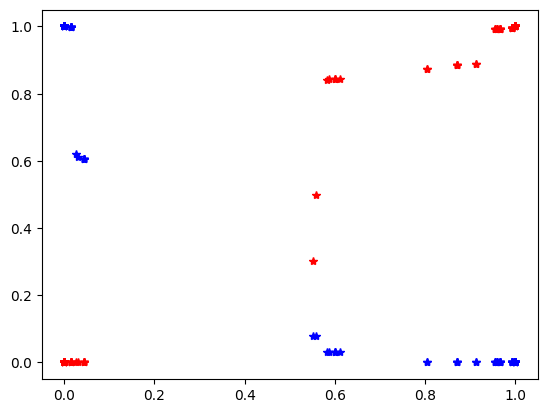

In [12]:
plt.plot(data_tmp['snw'],data_tmp['kr_air'],'r*')
plt.plot(data_tmp['snw'],data_tmp['kr_water'],'b*')